In [81]:
import json
import pandas as pd
from types import SimpleNamespace
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

experiments.json structure
- strategies
  - fedadam
    - epoch_1
      - exp_0
        - summary: path/to/summary/file
        - client_0
          - fittimes: path/to/fittimes/file
          - energy: path/to/energy/file
          - evalresult: path/to/evalresult/file
          - monitoring: path/to/monitoring/file
          - processes: path/to/processes/file
          - client_log: path/to/client_log/file
          - fitresult: path/to/fitresult/file
          - logs: path/to/logs/file
          - network: path/to/network/file
          - pid: path/to/pid/file
        - client_1
          - ... similar structure as client_0
        - server
          - energy: path/to/energy/file
          - monitoring: path/to/monitoring/file
          - processes: path/to/processes/file
          - results: path/to/results/file
          - logs: path/to/logs/file
          - network: path/to/network/file
          - server_log: path/to/server_log/file
      - exp_1
        - ... similar structure as exp_0


# Training Results

In [18]:
def flwr_pkl(path_to_pkl):
    """
    Load and return the contents of a pickle file.

    Parameters:
    path_to_pkl (str): The path to the pickle file.

    Returns:
    object: The deserialized object from the pickle file.
    """
    with open(path_to_pkl, "rb") as f:
        result = pkl.load(f)
    return result

def read_server(path_to_result):
    """_summary_

    Returns:
        SimpleNamespace[pd.DataFrame]: Contains energy, results as DataFrames
    """
    try :
        results = flwr_pkl(path_to_result)
    except FileNotFoundError as err:
        print(err)
        results = None
        results_df = None
    if results is not None:
        acc_centralized = [acc[1] for acc in results.metrics_centralized["accuracy"][1:]]
        acc_distributed = [acc[1] for acc in results.metrics_distributed["accuracy"]]
        losses_centralized = [loss[1] for loss in results.losses_centralized[1:]] # First loss is evaluated on initial parameters
        losses_distributed = [loss[1] for loss in results.losses_distributed]
        server_round = [i for i in range(1,len(acc_centralized)+1)]
        #print(len(server_round), len(acc_centralized), len(acc_distributed), len(losses_centralized), len(losses_distributed))
        results_df = pd.DataFrame(
            {
                "server_round": server_round,
                "acc_centralized": acc_centralized,
                "acc_distributed": acc_distributed,
                "losses_centralized": losses_centralized,
                "losses_distributed": losses_distributed   
            }
        )
    return results_df

In [19]:
with open('experiments.json','r') as f:
    strategies_dict = json.load(f)

In [94]:
def read_data_from_dict(strat_dict, strategy, epoch, exp, host, file_type):
    """
    Read data from a dictionary containing paths to data files.
    """
    path = strat_dict[strategy][epoch][exp][host][file_type]
    return path

def concat_server_results(strategy, epoch, host, file_type, n_exp = 5):
    """
    Concatenate server results from multiple experiments.
    """
    result_paths = [read_data_from_dict(strategies_dict, strategy, epoch, f'exp_{i}' , host, file_type) for i in range(n_exp)]
    result_dfs = []
    for path in result_paths:
        result_dfs.append(read_server(path))
    results_df = pd.concat(result_dfs, axis=1, keys=[f'exp_{i}' for i in range(n_exp)])
    return results_df

def average_results(results_df, column, n_exp=5):
    """
    Average results from multiple experiments.
    """
    concat = pd.concat([results_df.__getattr__(f'exp_{i}')[column] for i in range(n_exp)],axis=1)
    avg_df = concat.mean(axis=1)
    std_df = concat.std(axis=1)
    lower = avg_df - std_df
    upper = avg_df + std_df
    final_df = pd.DataFrame({f"{column}_avg": avg_df, f"{column}_std": std_df, f"{column}_lower_bound": lower, f"{column}_upper_bound": upper})
    return final_df



In [104]:
epoch = 'epoch_1' 
strategies = ['fedavg', 'fedyogi', 'fedadam', 'fedadagrad']

def compute_strategy_averages_results(strategies, epoch, metric):
    stratavg = []
    for strat in strategies:
        strat_concat = concat_server_results(strat, epoch, 'server', 'results')
        strat_avg = average_results(strat_concat, metric)
        stratavg.append(strat_avg)
    final_data = pd.concat(stratavg, axis=1, keys=strategies)
    return final_data

final_data = compute_strategy_averages_results(strategies, epoch, 'acc_distributed')


In [105]:
def plot_results(strategies, epoch, metric):
    """
    Plot results from multiple experiments.
    """
    data = compute_strategy_averages_results(strategies, epoch, metric)
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    for strat in strategies:
        axs.plot(data[strat][f'{metric}_avg'], label=strat)
        axs.fill_between(data[strat].index, data[strat][f'{metric}_lower_bound'], data[strat][f'{metric}_upper_bound'], alpha=0.2)
    plt.legend()
    plt.show()

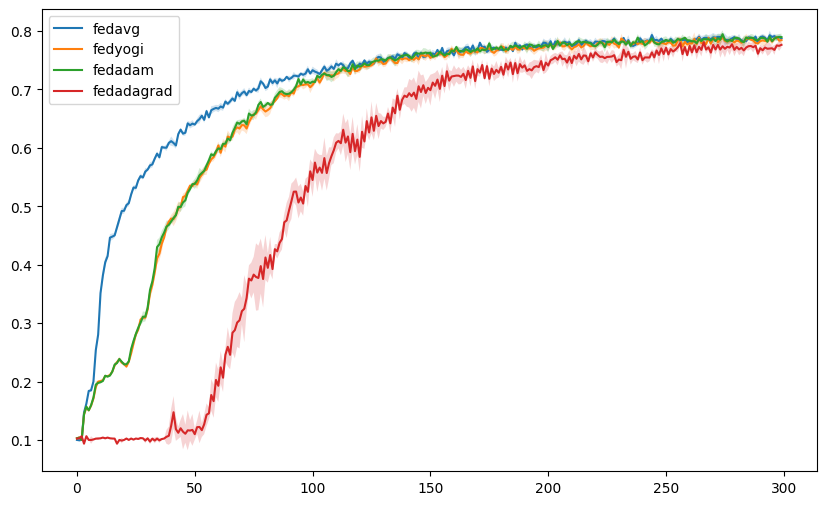

In [109]:
plot_results(strategies, epoch, 'acc_distributed')

# Energy

In [114]:
ok = pd.read_csv(strategies_dict['fedavg']['epoch_1']['exp_1']['server']['energy'])

In [115]:
ok

,timestamp,RAM%,GPU%,GPU inst power (mW),GPU avg power (mW),CPU%,CPU inst power (mW),CPU avg power (mW),tot inst power (mW),tot avg power (mW)
0,2024-04-22 22:40:26.523723,5,0,0,0,987,2586,2586,8211,8211
1,2024-04-22 22:40:27.501221,5,0,0,0,800,1438,2012,6968,7589
2,2024-04-22 22:40:28.503066,5,0,0,0,475,1247,1629,6780,7183
3,2024-04-22 22:40:29.501093,5,0,0,0,312,1151,1390,6684,6933
4,2024-04-22 22:40:30.501944,5,0,0,0,300,1055,1222,6588,6759
...,...,...,...,...,...,...,...,...,...,...
7580,2024-04-23 00:46:50.545216,5,0,0,0,300,1151,1151,6724,6724
7581,2024-04-23 00:46:51.546284,5,0,0,0,300,1151,1151,6724,6724
7582,2024-04-23 00:46:52.546336,5,0,0,0,325,1151,1151,6724,6724
7583,2024-04-23 00:46:53.546459,5,0,0,0,250,1151,1151,6724,6724
